# Graph Neural Networks
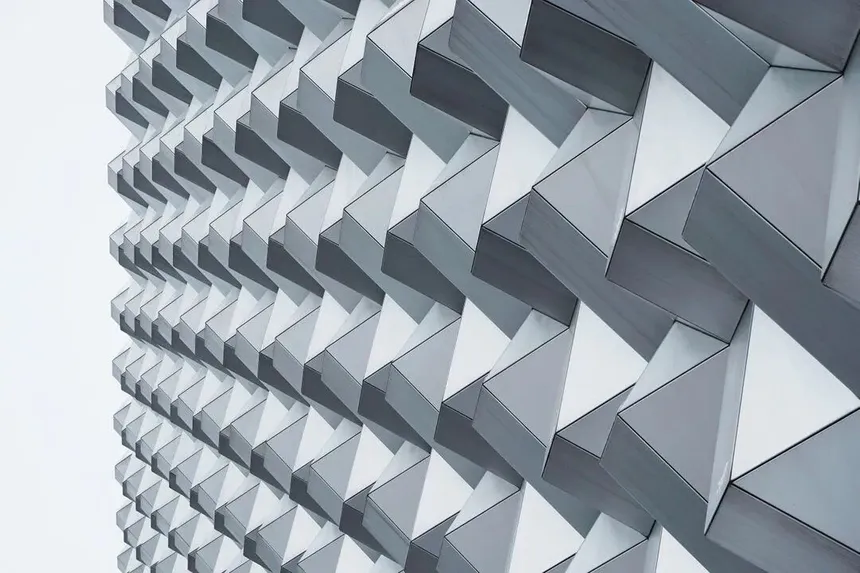

The key design element of GNNs is the use of pairwise message passing, such that graph nodes iteratively update their representations by exchanging information with their neighbors.


### **Import Libraries**

In [2]:

import os
import json
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from matplotlib import colormaps, colors



import torch
import torch_geometric as tg
from nilearn import datasets, maskers, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

warnings.filterwarnings('ignore')

### **Load Data**

In [11]:
# Load the Atlas File

dim = 64
difumo = datasets.fetch_atlas_difumo(dimension=dim, resolution_mm=2, legacy_format=False)

atlas_filename = difumo.maps
difumo_labels = difumo.labels

marker_labels = difumo_labels['difumo_names'].tolist() 

In [ ]:
# Grab center coordinates for probabilistic atlas
coords = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps)

In [4]:
# Load the fMRI Dataset
dataset = datasets.fetch_development_fmri()
pheno = pd.DataFrame(dataset.phenotypic)

# Mapping 'Child_Adult' to a binary format
pheno['Adult'] = pheno['Child_Adult'].map({'adult': 1, 'child': 0})

print('Keys:',list(dataset.keys()))
print('Number of subjects:', len(pheno))

Keys: ['func', 'confounds', 'phenotypic', 'description']
Number of subjects: 155


### **Matrix Transformation**

The use of `vectorize=True` and `discard_diagonal=True` in the `ConnectivityMeasure` class explains why your features are of size 2016 instead of 4096 (which would be the size if the full 64x64 matrix was kept).

Here's how it works:

- **Original Matrix**: The full connectivity matrix for each subject is 64x64.
- **Discard Diagonal**: Since the diagonal elements are discarded, you're left with  64 \times 64 - 64 = 4032  elements (excluding the diagonal).
- **Symmetry**: The connectivity matrix is symmetric, so only the upper (or lower) triangular part is retained, which contains  frac{64 \times (64 - 1)}{2} = 2016  unique values.




In [6]:
# Load the features

feat_file = 'Age_Classf_featuress.npz'
X_features = np.load(feat_file)['a']

print('Features shape:', X_features.shape)

Features shape: (155, 2016)


In [57]:
import numpy as np

# Define the dimensions for the full matrix
matrix_size = 64

# Function to recreate the full matrix from vectorized features
def vector_to_symmetric_matrix(vector, size):
    # Create an empty matrix
    full_matrix = np.zeros((size, size))
    
    # Fill the upper triangle (excluding diagonal)
    full_matrix[np.triu_indices(size, k=1)] = vector
    
    # Reflect the upper triangle to the lower triangle
    full_matrix += full_matrix.T
    
    return full_matrix

# Apply the function to each feature in X_features
reshaped_features = []
for feature in X_features:
    reshaped_feature = vector_to_symmetric_matrix(feature, matrix_size)
    reshaped_features.append(reshaped_feature)

# Convert reshaped_features list to a numpy array
reshaped_features = np.array(reshaped_features)

# Now reshaped_features is a numpy array of shape (155, 64, 64)
print('Reshaped features dimension:', reshaped_features.shape)  # Should print (155, 64, 64)


Reshaped features dimension: (155, 64, 64)


In [8]:
# Separate the matrix into two groups based on the 'Adult' column
adult_matrix = reshaped_features[pheno['Adult'] == 1]  # For adults
child_matrix = reshaped_features[pheno['Adult'] == 0]  # For children

# Print the shapes of the new matrices
print('Adult matrix shape:', adult_matrix.shape)
print('Child matrix shape:', child_matrix.shape)

Adult matrix shape: (33, 64, 64)
Child matrix shape: (122, 64, 64)


In [9]:
# Compute the mean across subjects for each group
mean_adult_matrix = np.mean(adult_matrix, axis=0)
mean_child_matrix = np.mean(child_matrix, axis=0)

# Print the shapes of the resulting matrices
print('Mean Adult matrix shape:', mean_adult_matrix.shape)
print('Mean Child matrix shape:', mean_child_matrix.shape)

Mean Adult matrix shape: (64, 64)
Mean Child matrix shape: (64, 64)


In [26]:
import numpy as np
import pandas as pd

def get_correlations(feat_exp_matrix, marker_labels, p_threshold=0.4, n_threshold=-0.2):
    # Ensure the input matrix is a numpy array
    feat_exp_matrix = np.array(feat_exp_matrix)
    
    # Initialize lists to store results
    results = []

    # Iterate over the lower triangular part of the matrix
    num_labels = len(marker_labels)
    for i in range(num_labels):
        for j in range(i):  # Only consider j < i to focus on the lower triangular part
            value = feat_exp_matrix[i, j]
            if value >= p_threshold or value < n_threshold:
                results.append((marker_labels[i], marker_labels[j], value))
    
    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['Marker1', 'Marker2', 'Correlation'])
    
    # Sort the DataFrame by the 'Correlation' column in descending order
    df_sorted = df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    
    return df_sorted

# Example usage:
marker_corr = get_correlations(mean_adult_matrix, marker_labels)
marker_corr.head(5)


Marker1                     Marker2  Correlation
0     Callosomarginal sulcus  Postcentral gyrus inferior     0.823390
1                     Cuneus                  ventricles     0.811754
2             Cerebellum I-V              Fusiform gyrus     0.786213
3  Superior occipital sulcus        Intraparietal sulcus     0.765925
4         Precuneus superior            Transverse sinus     0.765584

### **3D Networks**

In [35]:

def visualize_connectome(df_sorted, coords, marker_labels, cmap_markers='viridis', cmap_edges='Paired'):
    # Ensure marker_labels is a list
    if isinstance(marker_labels, pd.Index):
        marker_labels = marker_labels.tolist()

    # Extract unique markers from the top rows
    unique_markers = pd.unique(df_sorted[['Marker1', 'Marker2']].values.ravel('K'))

    # Filter marker labels and coordinates to only include those in unique_markers
    filtered_indices = [i for i, label in enumerate(marker_labels) if label in unique_markers]
    filtered_coords = coords[filtered_indices]
    filtered_labels = [marker_labels[i] for i in filtered_indices]

    # Normalize correlations for color mapping
    norm = colors.Normalize(vmin=df_sorted['Correlation'].min(), vmax=df_sorted['Correlation'].max())
    cmap_markers = colormaps.get_cmap(cmap_markers)
    cmap_edges = colormaps.get_cmap(cmap_edges)

    # Create a Plotly figure
    fig = go.Figure()

    # Add nodes to the plot
    fig.add_trace(go.Scatter3d(
        x=filtered_coords[:, 0],
        y=filtered_coords[:, 1],
        z=filtered_coords[:, 2],
        mode='markers+text',
        marker=dict(size=8, color=[colors.to_hex(cmap_markers(norm(c))) for c in df_sorted['Correlation']]),  # Use cmap for node colors
        text=filtered_labels,
        textfont=dict(color='white', size=13, family="Arial"),  # Larger font size
        textposition='middle right',  # Position labels on the right
        name='Markers'
    ))

    # Add edges to the plot
    for i, row in df_sorted.iterrows():
        marker1 = row['Marker1']
        marker2 = row['Marker2']
        correlation = row['Correlation']

        marker1_idx = filtered_labels.index(marker1)
        marker2_idx = filtered_labels.index(marker2)

        fig.add_trace(go.Scatter3d(
            x=[filtered_coords[marker1_idx, 0], filtered_coords[marker2_idx, 0]],
            y=[filtered_coords[marker1_idx, 1], filtered_coords[marker2_idx, 1]],
            z=[filtered_coords[marker1_idx, 2], filtered_coords[marker2_idx, 2]],
            mode='lines',
            line=dict(color=colors.to_hex(cmap_edges(norm(correlation))), width=3),  # Use cmap for edge colors
            name=f"{marker1} - {marker2} ({correlation:.2f})"
        ))

    # Update layout
    fig.update_layout(
        title=dict(
            text='',
            x=0.5,  # Center the title
            y=0.95,  # Move the title slightly up to avoid overlap
            font=dict(size=26, color='white', family="Arial")
        ),
        paper_bgcolor='black',  # Black background for the entire figure
        plot_bgcolor='black',   # Black background for the plot area
        scene=dict(
            xaxis=dict(
                title=dict(text='X', font=dict(size=18, color='white')),
                showbackground=False,
                showgrid=True,
                gridcolor='rgba(50, 50, 50, 0.5)',  # Dark gray gridlines
                showline=True,
                linecolor='white',  # White axis lines
                showticklabels=False,
                zeroline=False
            ),
            yaxis=dict(
                title=dict(text='Y', font=dict(size=18, color='white')),
                showbackground=False,
                showgrid=True,
                gridcolor='rgba(50, 50, 50, 0.5)',  # Dark gray gridlines
                showline=True,
                linecolor='white',
                showticklabels=False,
                zeroline=False
            ),
            zaxis=dict(
                title=dict(text='Z', font=dict(size=18, color='white')),
                showbackground=False,
                showgrid=True,
                gridcolor='rgba(50, 50, 50, 0.5)',  # Dark gray gridlines
                showline=True,
                linecolor='white',
                showticklabels=False,
                zeroline=False
            )
        ),
        margin=dict(
            l=20,  # Adjusted margins for better spacing
            r=20,
            b=20,
            t=20
        ),
        width=600,  # Width of the plot
        height=400,  # Height of the plot
        showlegend=True,
        legend=dict(
            x=0.0,  # Center the title
            y=-0.2,  # Move the title slightly up to avoid overlap
            font=dict(size=10, color='white', family="Arial"),  # White font for the legend
            bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the legend
        )
    )

    # Show the plot
    fig.show()

In [63]:

plotting.view_connectome(mean_adult_matrix, coords, edge_threshold=0.77,
                        edge_cmap='plasma_r', colorbar=True)

In [62]:
visualize_connectome(marker_corr.head(3), coords, marker_labels, cmap_markers='Paired', cmap_edges='cool')

### The next step is to construct the brain graph for GCN.

__k-Nearest Neighbours(KNN) graph__ for the group average connectome will be built based on the connectivity-matrix.

Each node is only connected to *k* conn = corr_measure.fit_transform([X])[0]
other neighbouring nodes.
For the purpose of demostration, we constrain the graph to from clusters with __8__ neighbouring nodes with the strongest connectivity.


In [64]:
def _make_undirected(mat):
    """
    Takes an input adjacency matrix and makes it undirected (symmetric).

    Parameter
    ----------
    mat: array
        Square adjacency matrix.
    """
    if mat.shape[0] != mat.shape[1]:
        raise ValueError("Adjacency matrix must be square.")

    sym = (mat + mat.transpose()) / 2
    if len(np.unique(mat)) == 2:  # if graph was unweighted, return unweighted
        return np.ceil(sym)  # otherwise return average
    return sym


def _knn_graph_quantile(mat, self_loops=False, k=8, symmetric=True):
    """
    Takes an input correlation matrix and returns a k-Nearest
    Neighbour weighted undirected adjacency matrix.
    """

    if mat.shape[0] != mat.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    dim = mat.shape[0]
    if (k <= 0) or (dim <= k):
        raise ValueError("k must be in range [1,n_nodes)")
    is_directed = not (mat == mat.transpose()).all()
    if is_directed:
        raise ValueError(
            "Input adjacency matrix must be undirected (matrix symmetric)!"
        )

    # absolute correlation
    mat = np.abs(mat)
    adj = np.copy(mat)
    # get NN thresholds from quantile
    quantile_h = np.quantile(mat, (dim - k - 1) / dim, axis=0)
    mask_not_neighbours = mat < quantile_h[:, np.newaxis]
    adj[mask_not_neighbours] = 0
    if not self_loops:
        np.fill_diagonal(adj, 0)
    if symmetric:
        adj = _make_undirected(adj)
    return adj


def make_group_graph(connectomes, k=8, self_loops=False, symmetric=True):
    """
    Parameters
    ----------
    connectomes: list of array
        List of connectomes in n_roi x n_roi format, connectomes must all be the same shape.
    k: int, default=8
        Number of neighbours.
    self_loops: bool, default=False
        Wether or not to keep self loops in graph, if set to False resulting adjacency matrix
        has zero along diagonal.
    symmetric: bool, default=True
        Wether or not to return a symmetric adjacency matrix. In cases where a node is in the neighbourhood
        of another node that is not its neighbour, the connection strength between the two will be halved.

    Returns
    -------
    Torch geometric graph object of k-Nearest Neighbours graph for the group average connectome.
    """
    if connectomes[0].shape[0] != connectomes[0].shape[1]:
        raise ValueError("Connectomes must be square.")

    # Group average connectome and nndirected 8 k-NN graph
    avg_conn = np.array(connectomes).mean(axis=0)
    avg_conn = np.round(avg_conn, 6)
    avg_conn_k = _knn_graph_quantile(
        avg_conn, k=k, self_loops=self_loops, symmetric=symmetric
    )

    # Format matrix into graph for torch_geometric
    adj_sparse = tg.utils.dense_to_sparse(torch.from_numpy(avg_conn_k))
    return tg.data.Data(edge_index=adj_sparse[0], edge_attr=adj_sparse[1])


In [65]:
# Enforce Symmetry

conn = (mean_adult_matrix + mean_adult_matrix.T) / 2

In [66]:
# make a graph for one subject

mean_adult_graph = make_group_graph([conn], self_loops=False, k=8, symmetric=True)


### **Visualize the Graph Network**

- **Control Networks:** Involved in high-level executive functions like decision-making and attention control.
- **Default Mode Network (DMN):** Involved in self-referential thought, memory, and social cognition.
- **Dorsal Attention Network (DAN):** Supports goal-directed attention and eye movements.
- **Salience Network (SN):** Detects and responds to critical stimuli, integrating emotion and attention.
- **Somatomotor Networks:** Manage sensory input and motor output, coordinating body movement and sensation.
- **Visual Networks:** Process visual information, supporting everything from simple object recognition to complex spatial awareness.

In [67]:
# k-nn graph 
def brain_graph_Yeo17(graph, difumo_labels, color_map=None, layout='kamada_kawai', node_size=200, edge_width=1.5, alpha=0.6, figsize=(14, 14),Upper_title="Connectivity Graph: Yeo Networks"):
    """
    Plots a brain connectivity graph with nodes colored according to Yeo networks.

    Parameters:
    - graph: PyTorch Geometric graph containing edge_index.
    - difumo_labels: DataFrame containing 'difumo_names' and 'yeo_networks17'.
    - color_map: Dictionary mapping Yeo networks to colors. Default is None, which sets a predefined color map.
    - layout: String specifying the layout for the graph ('kamada_kawai' or 'spring').
    - node_size: Size of the nodes in the graph.
    - edge_width: Width of the edges in the graph.
    - alpha: Transparency of the edges.
    - figsize: Tuple specifying the size of the figure.
    """
    # Suppress DeprecationWarning
    warnings.filterwarnings('ignore', category=DeprecationWarning)

    # Convert edge_index from PyTorch Geometric to numpy
    edge_index = graph.edge_index.numpy()
    edges = edge_index.T

    # Create a NetworkX graph from the edge indices
    G = nx.Graph()
    G.add_edges_from(edges)

    # Assuming labels is a list of ROI names from difumo_labels['difumo_names'].tolist()
    labels = difumo_labels['difumo_names'].tolist()

    # Define a default colormap for the Yeo networks if not provided
    if color_map is None:
        color_map = {
            'ContA': '#1f77b4', 'ContB': '#ff7f0e', 'ContC': '#2ca02c',
            'DefaultA': '#d62728', 'DefaultB': '#9467bd', 'DefaultC': '#8c564b',
            'DorsAttnA': '#e377c2', 'DorsAttnB': '#7f7f7f', 
            'SalVentAttnA': '#bcbd22', 'SalVentAttnB': '#17becf',
            'SomMotA': '#aec7e8', 'SomMotB': '#ffbb78',
            'TempPar': '#98df8a', 'VisCent': '#ff9896', 'VisPeri': '#c5b0d5',
            'No network found': '#c49c94'
        }

    # Generate a list of node colors based on their Yeo networks using the difumo_labels DataFrame
    node_colors = []
    for roi in labels:
        # Find the Yeo network for this ROI from the difumo_labels DataFrame
        yeo_network = difumo_labels.loc[difumo_labels['difumo_names'] == roi, 'yeo_networks17'].values[0]

        # Get the color for this Yeo network
        color = color_map.get(yeo_network, color_map['No network found'])
        node_colors.append(color)

    # Choose the layout for graph visualization
    if layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)

    # Create the plot
    plt.figure(figsize=figsize)

    # Draw nodes with colors based on Yeo networks
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, edgecolors='white')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=alpha, edge_color='purple')

    # Map the ROI labels to the nodes
    node_labels = {i: labels[i] for i in range(len(G.nodes))}

    # Draw labels (optional)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=11, font_family='sans-serif',
                             font_color='black',verticalalignment = 'bottom')

    # Create a legend to map colors to Yeo networks
    handles = [mpatches.Patch(color=color_map[network], label=network) for network in color_map]
    plt.legend(handles=handles, loc='upper right', fontsize=12, title="Yeo Networks", title_fontsize='13')

    # Title and plot settings
    plt.title(Upper_title, fontsize=20, fontweight='bold')
    plt.axis('off')  # Hide the axis

    # Show the plot
    plt.show()


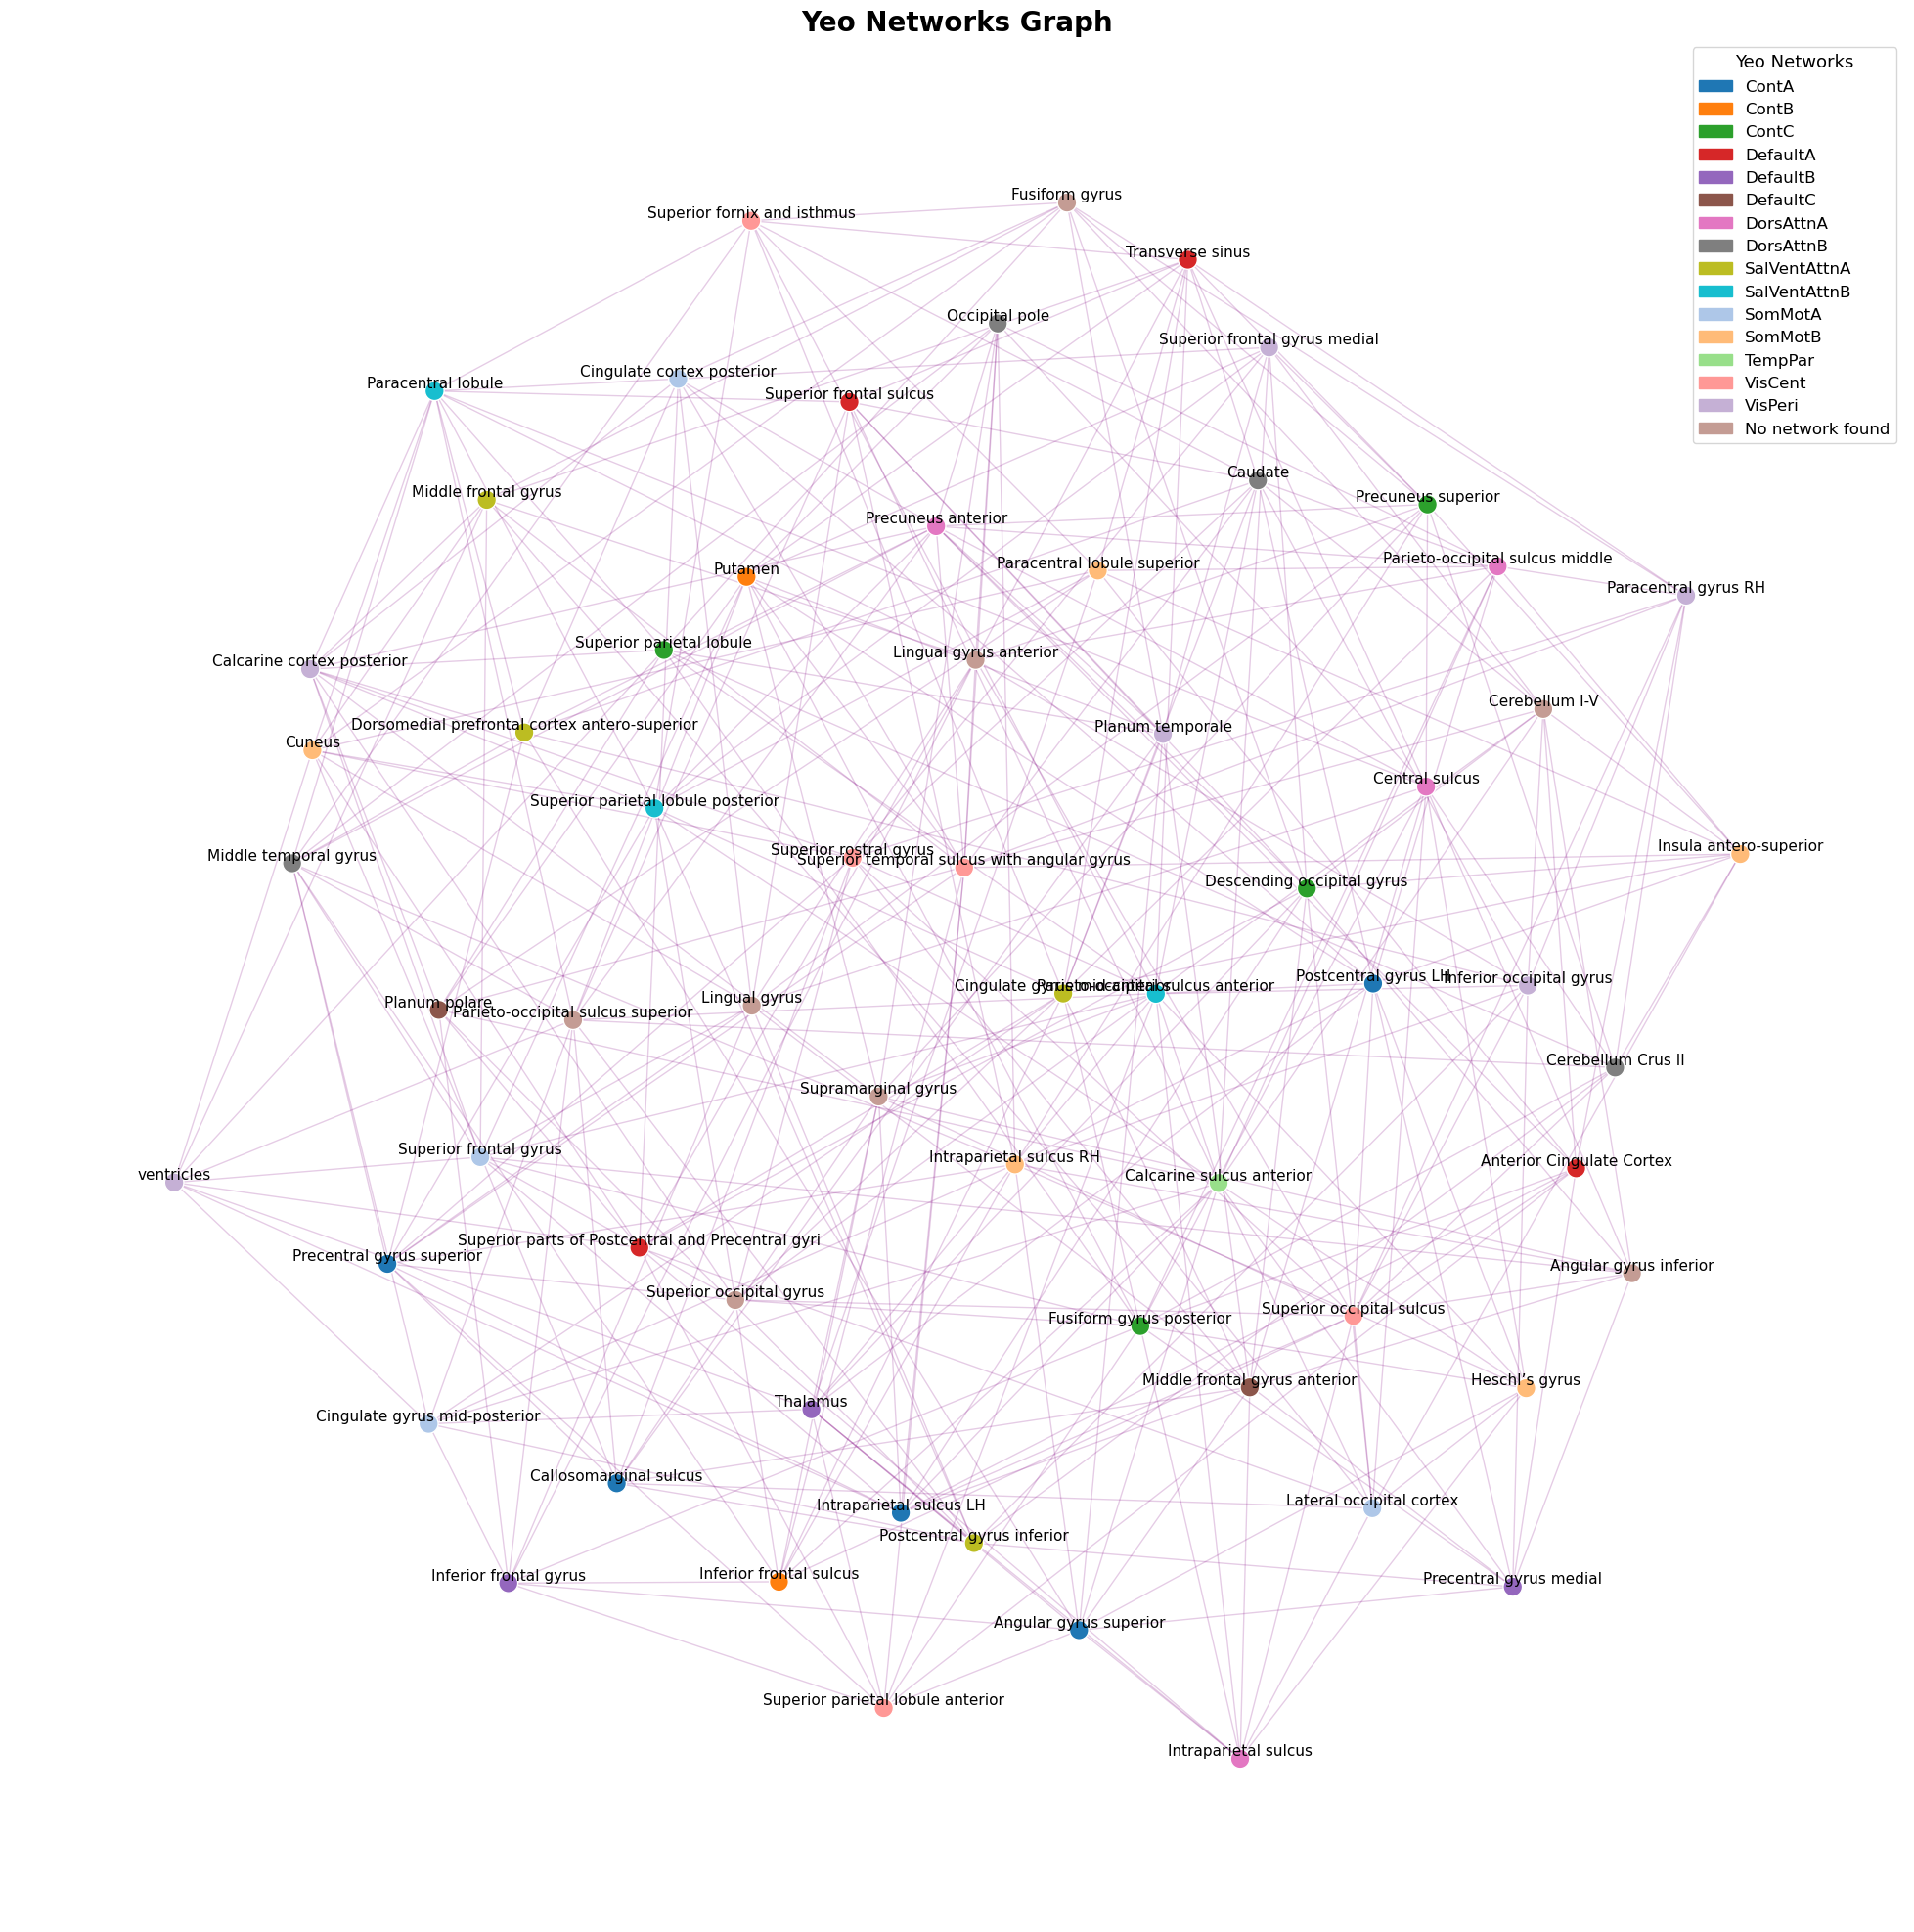

In [71]:
visualize_graph = brain_graph_Yeo17(mean_adult_graph, difumo_labels,Upper_title='Yeo Networks Graph', color_map=None, layout='kamada_kawai', node_size=200, edge_width=1, alpha=0.2, figsize=(25, 25))